In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA

In [3]:

dataset_path = '/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360/'

train_path = '/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360/Training'
test_path = '/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360/Test'

available_classes = os.listdir(train_path)
#print("Available classes in the training set:", available_classes)

selected_classes = ['Avocado 1', 'Apple 6', 'Pepper Green 1', 'Lemon 1', 'Mango 1']


missing_classes = [fruit for fruit in selected_classes if fruit not in available_classes]
print("Missing classes:", missing_classes)


Missing classes: []


In [4]:
def load_selected_classes(folder_path, selected_classes):
    images = []
    labels = []
    for fruit_folder in os.listdir(folder_path):
        if fruit_folder in selected_classes:  # Filter for selected classes
            fruit_path = os.path.join(folder_path, fruit_folder)
            for image_file in os.listdir(fruit_path):
                image_path = os.path.join(fruit_path, image_file)
                image = Image.open(image_path).resize((64, 64)).convert('L')  # Resize and grayscale
                images.append(np.array(image).flatten())  # Flatten image to 1D array
                labels.append(fruit_folder)
    return np.array(images), np.array(labels)

# Load training and test data for selected classes
X_train, y_train = load_selected_classes(train_path, selected_classes)
X_test, y_test = load_selected_classes(test_path, selected_classes)

In [5]:

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)


In [18]:

logistic_model = LogisticRegression(max_iter=1000, multi_class='ovr', random_state=42)

logistic_model.fit(X_train, y_train)

y_proba = logistic_model.predict_proba(X_test)

y_pred_logistic = logistic_model.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logistic))
print("\n________________________\n")
print(classification_report(y_test, y_pred_logistic, target_names=selected_classes))


Logistic Regression Accuracy: 0.980719794344473

________________________

                precision    recall  f1-score   support

     Avocado 1       1.00      1.00      1.00       157
       Apple 6       1.00      0.90      0.94       143
Pepper Green 1       1.00      1.00      1.00       164
       Lemon 1       0.92      1.00      0.96       166
       Mango 1       1.00      1.00      1.00       148

      accuracy                           0.98       778
     macro avg       0.98      0.98      0.98       778
  weighted avg       0.98      0.98      0.98       778



In [7]:

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_pred_proba = knn_model.predict_proba(X_test)

y_pred_knn = knn_model.predict(X_test)
print("KNN Classifier Accuracy:", accuracy_score(y_test, y_pred_knn))
print("\n________________________\n")
print(classification_report(y_test, y_pred_knn, target_names=selected_classes))


KNN Classifier Accuracy: 0.9781491002570694

________________________

                precision    recall  f1-score   support

     Avocado 1       1.00      1.00      1.00       157
       Apple 6       1.00      0.88      0.94       143
Pepper Green 1       1.00      1.00      1.00       164
       Lemon 1       0.91      1.00      0.95       166
       Mango 1       1.00      1.00      1.00       148

      accuracy                           0.98       778
     macro avg       0.98      0.98      0.98       778
  weighted avg       0.98      0.98      0.98       778



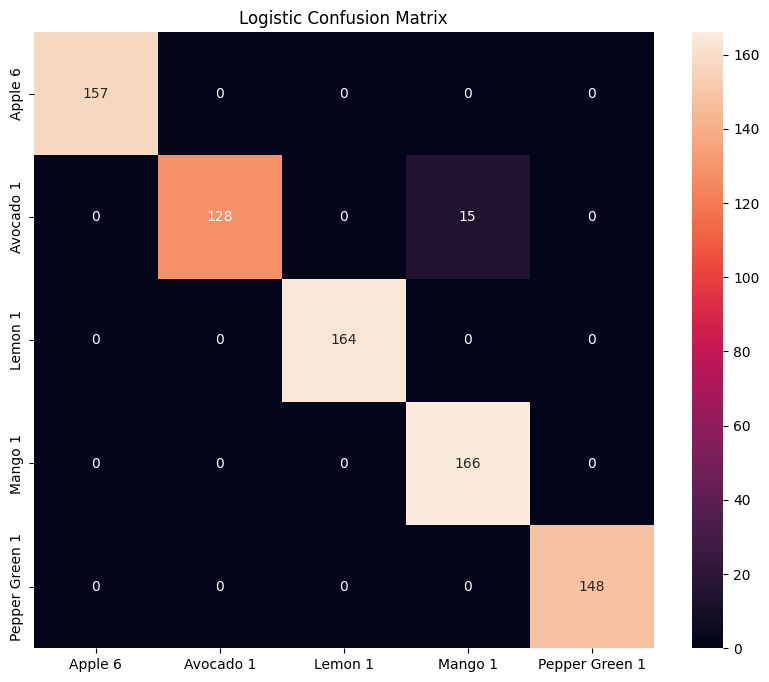

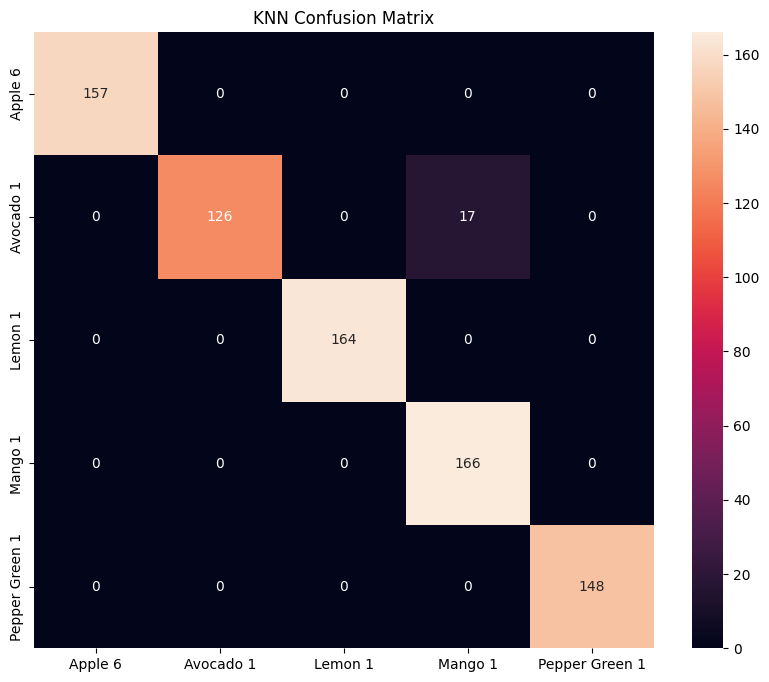

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_logistic)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Logistic Confusion Matrix")
plt.show()

cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("KNN Confusion Matrix")
plt.show()


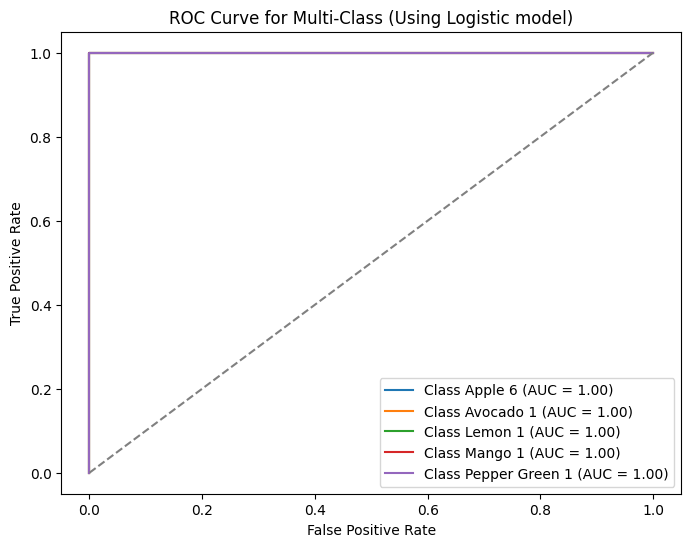

In [24]:
y_test_bin = label_binarize(y_test, classes=np.arange(len(encoder.classes_)))

y_pred_bin_logistic = logistic_model.predict_proba(X_test)

# Compute ROC and AUC for each class(logistic model)
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin_logistic[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(len(encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class (Using Logistic model)')
plt.legend(loc='lower right')
plt.show()


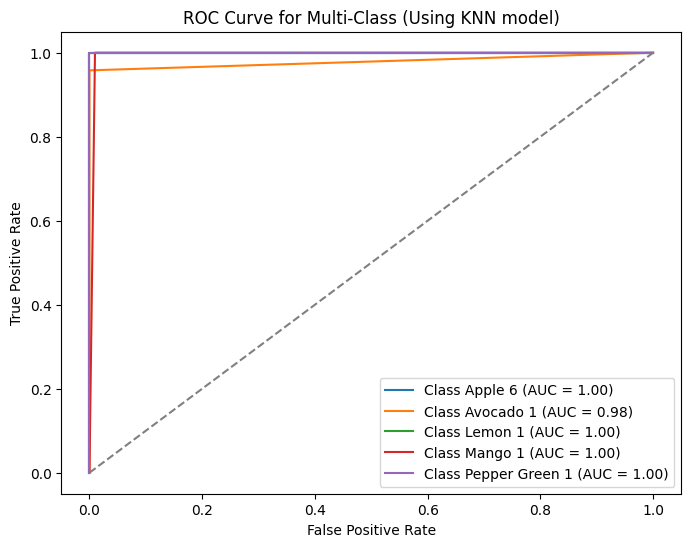

In [25]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


y_test_bin = label_binarize(y_test, classes=np.arange(len(encoder.classes_)))
y_pred_bin_knn = knn_model.predict_proba(X_test)  

# Compute ROC and AUC for each class(KNN model)
fpr_knn, tpr_knn, roc_auc_knn = {}, {}, {}
for i in range(len(encoder.classes_)):
    fpr_knn[i], tpr_knn[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin_knn[:, i])
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])


# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(len(encoder.classes_)):
    plt.plot(fpr_knn[i], tpr_knn[i], label=f'Class {encoder.classes_[i]} (AUC = {roc_auc_knn[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class (Using KNN model)')
plt.legend(loc='lower right')
plt.show()


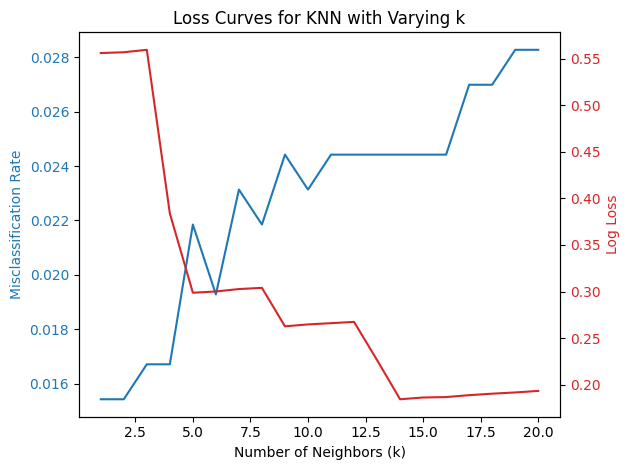

In [10]:

misclassification_rates = []
log_losses = []

k_values = range(1, 21) 


for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    
    model.fit(X_train, y_train)
    
    y_test_pred = model.predict(X_test)

    test_accuracy = accuracy_score(y_test, y_test_pred)
    misclassification_rate = 1 - test_accuracy
    misclassification_rates.append(misclassification_rate)
    
    try:
        y_test_prob = model.predict_proba(X_test)
        log_loss_value = log_loss(y_test, y_test_prob)
        log_losses.append(log_loss_value)
    except ValueError:
        log_losses.append(np.nan)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Number of Neighbors (k)')
ax1.set_ylabel('Misclassification Rate', color='tab:blue')
ax1.plot(k_values, misclassification_rates, color='tab:blue', label='Misclassification Rate')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Log Loss', color='tab:red')
ax2.plot(k_values, log_losses, color='tab:red', label='Log Loss')
ax2.tick_params(axis='y', labelcolor='tab:red')


plt.title('Loss Curves for KNN with Varying k')
fig.tight_layout()
plt.show()


In [26]:
print("loss of logistic regression: ", (log_loss(y_test,y_proba)))
print("loss of knn regression: ", (log_loss(y_test,knn_pred_proba)))

loss of logistic regression:  0.03366540082437841
loss of knn regression:  0.29876342345512225


In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Comparison of Logistic Regression and KNN
print("\nComparison Between Logistic Regression and KNN Classifier:")

# Metrics for Logistic Regression
precision_logistic = precision_score(y_test, y_pred_logistic, average='macro')
recall_logistic = recall_score(y_test, y_pred_logistic, average='macro')
f1_logistic = f1_score(y_test, y_pred_logistic, average='macro')
accuracy_score_logistic = accuracy_score(y_test, y_pred_logistic)

print("Logistic Regression Accuracy:",accuracy_score_logistic )
print(f"Logistic Regression - Precision: {precision_logistic:.2f}, Recall: {recall_logistic:.2f}, F1 Score: {f1_logistic:.2f}")
print("\n________________________\n")

# Metrics for KNN
precision_knn = precision_score(y_test, y_pred_knn, average='macro')
recall_knn = recall_score(y_test, y_pred_knn, average='macro')
f1_knn = f1_score(y_test, y_pred_knn, average='macro')
accuracy_score_knn = accuracy_score(y_test, y_pred_knn)

print("KNN Classifier Accuracy:",accuracy_score_knn )
print(f"KNN Classifier - Precision: {precision_knn:.2f}, Recall: {recall_knn:.2f}, F1 Score: {f1_knn:.2f}")
print("\n________________________\n")

if accuracy_score_logistic > accuracy_score_knn and  precision_logistic >= precision_knn and recall_logistic >= recall_knn and f1_logistic >= f1_knn:
    print("Logistic Regression is the better model based on Accuracy, Precision, Recall, and F1 Score.")
elif  accuracy_score_logistic < accuracy_score_knn and  precision_logistic <= precision_knn and recall_logistic <= recall_knn and f1_logistic <= f1_knn:
    print("KNN Classifier is the better model based on Accuracy, Precision, Recall, and F1 Score.")
else:
    print("Both Logistic Regression and KNN Classifier perform equally based on Accuracy, Precision, Recall, and F1 Score.")


Comparison Between Logistic Regression and KNN Classifier:
Logistic Regression Accuracy: 0.980719794344473
Logistic Regression - Precision: 0.98, Recall: 0.98, F1 Score: 0.98

________________________

KNN Classifier Accuracy: 0.9781491002570694
KNN Classifier - Precision: 0.98, Recall: 0.98, F1 Score: 0.98

________________________

Logistic Regression is the better model based on Accuracy, Precision, Recall, and F1 Score.
